In [32]:
# lendo os arquivos CSV
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# visualizando as primeiras linhas do conjunto de dados de treino
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# preparacao dos dados
X_train = train_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y_train = train_data['Survived']
X_test = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# preenchendo valores ausentes
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].median())
X_train['Fare'] = X_train['Fare'].fillna(X_train['Fare'].median())
X_train['Embarked'] = X_train['Embarked'].fillna(X_train['Embarked'].mode()[0])

X_test['Age'] = X_test['Age'].fillna(X_test['Age'].median())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].median())
X_test['Embarked'] = X_test['Embarked'].fillna(X_test['Embarked'].mode()[0])

# convertendo variaveis categoricas
le = LabelEncoder()
X_train['Sex'] = le.fit_transform(X_train['Sex'])
X_train['Embarked'] = le.fit_transform(X_train['Embarked'])

X_test['Sex'] = le.fit_transform(X_test['Sex'])
X_test['Embarked'] = le.fit_transform(X_test['Embarked'])

# visualizar os dados processados
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2
4,3,1,35.0,0,0,8.0500,2


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# parametros a serem testados
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# inicializando o modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# usando RandomizedSearchCV para otimização de hiperpametros
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# exibir o melhor modelo encontrado
random_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

   param_n_estimators  param_max_depth  param_min_samples_split  \
0                 100               10                        5   
1                 100                5                        2   
2                 200                5                        5   
3                 200               10                        5   
4                 100                5                        2   

   param_min_samples_leaf  mean_test_score  
0                       1         0.826056  
1                       1         0.820463  
2                       4         0.811500  
3                       1         0.833902  
4                       4         0.817111  


<Figure size 1200x600 with 0 Axes>

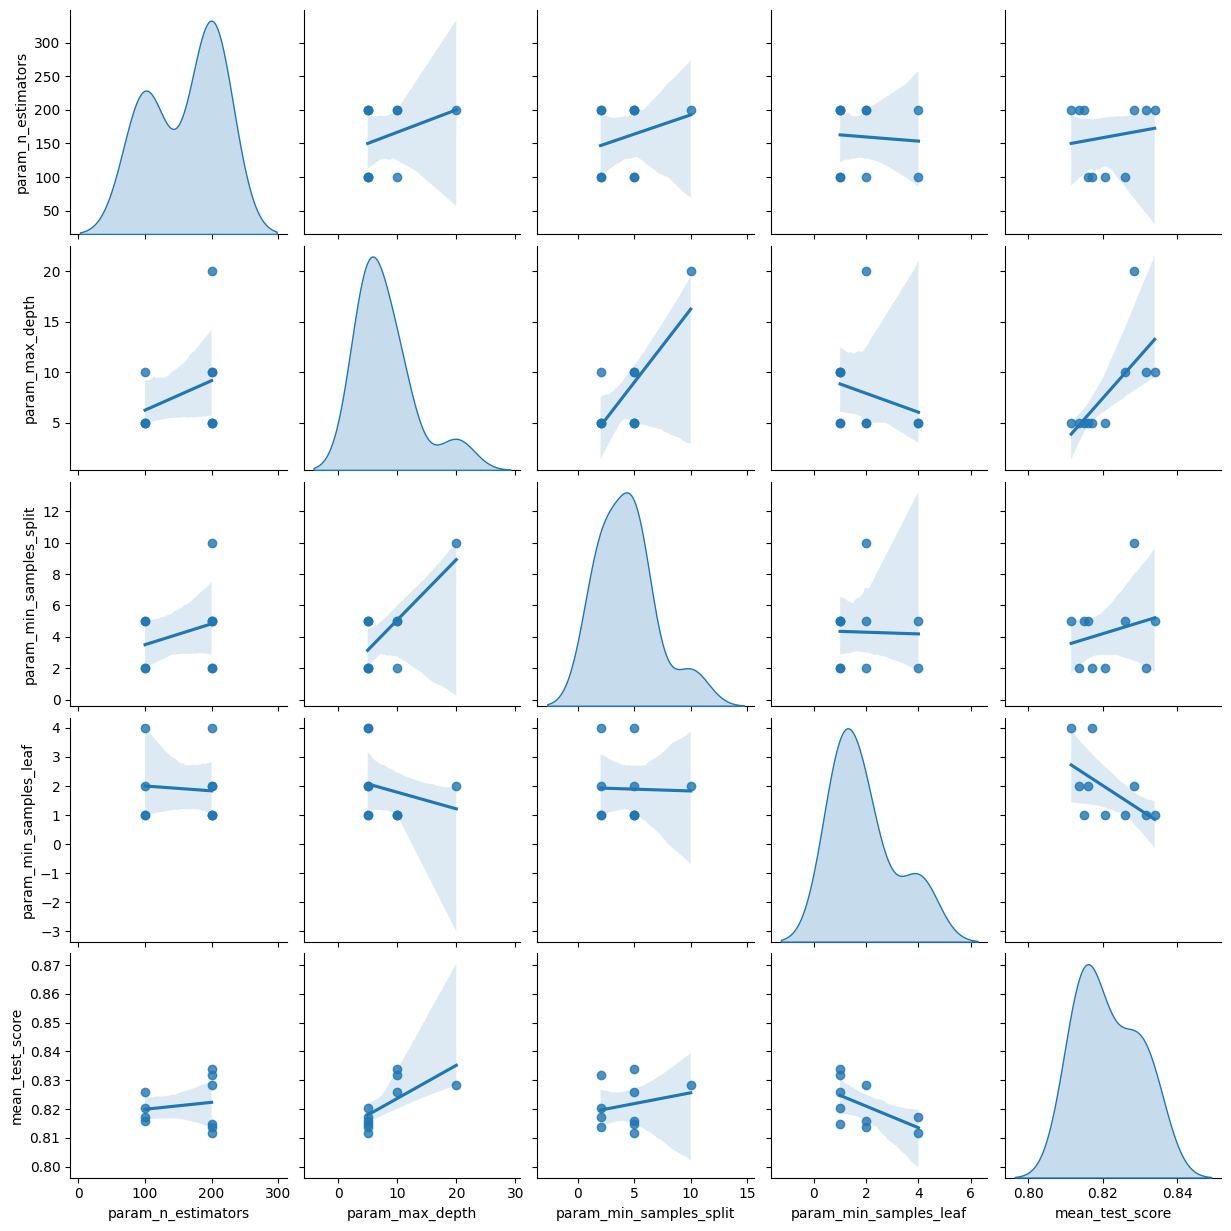

In [35]:
# funcao para exibir os resultados do RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

def plot_search_results(random_search):
    results = pd.DataFrame(random_search.cv_results_)
    results_numeric = results[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']]

    # exibe os primeiros resultados
    print(results_numeric.head())

    # ajusta o tamanho do grafico
    plt.figure(figsize=(12, 6))
    sns.pairplot(results_numeric, diag_kind='kde', kind='reg')
    plt.show()

# exibe os resultados
plot_search_results(random_search)

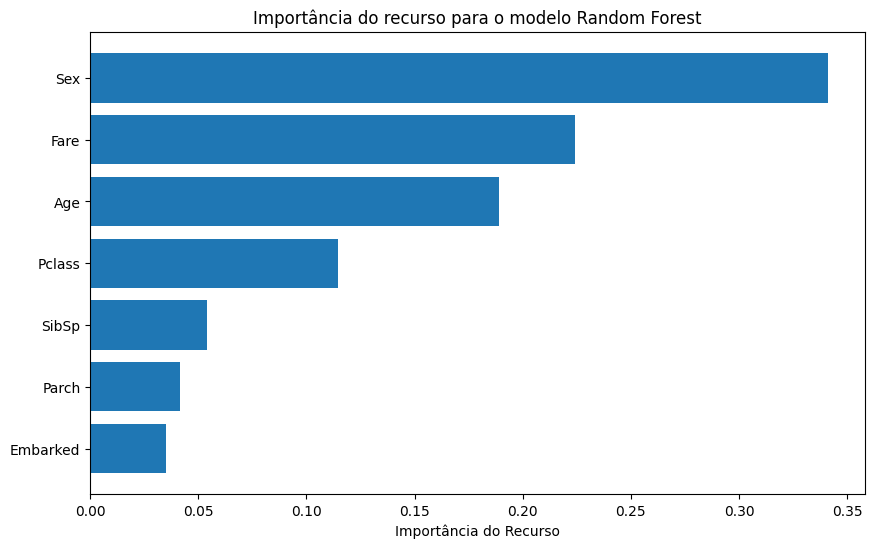

In [37]:
# funcao para plotar a importancia das features
def plot_feature_importances(model, X_train):
    feature_importances = model.feature_importances_
    features = X_train.columns
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(features[sorted_idx], feature_importances[sorted_idx])
    plt.xlabel("Importância do Recurso")
    plt.title("Importância do recurso para o modelo Random Forest")
    plt.show()

# exibindo a importancia das features
best_rf = random_search.best_estimator_
plot_feature_importances(best_rf, X_train)

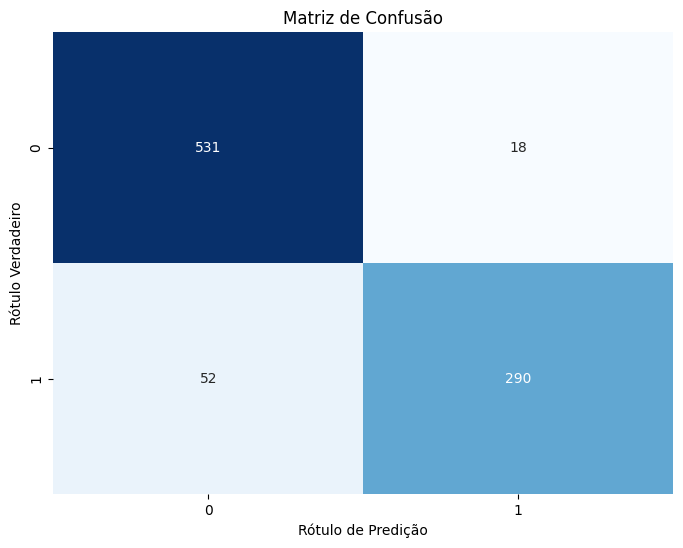

In [38]:
from sklearn.metrics import confusion_matrix

# funcao para plotar a matriz de confusao
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Matriz de Confusão")
    plt.ylabel("Rótulo Verdadeiro")
    plt.xlabel("Rótulo de Predição")
    plt.show()

# exibindo a matriz de confusao com os dados de treino
plot_confusion_matrix(y_train, best_rf.predict(X_train))

              precision    recall  f1-score     support
0              0.910806  0.967213  0.938163  549.000000
1              0.941558  0.847953  0.892308  342.000000
accuracy       0.921437  0.921437  0.921437    0.921437
macro avg      0.926182  0.907583  0.915235  891.000000
weighted avg   0.922610  0.921437  0.920562  891.000000


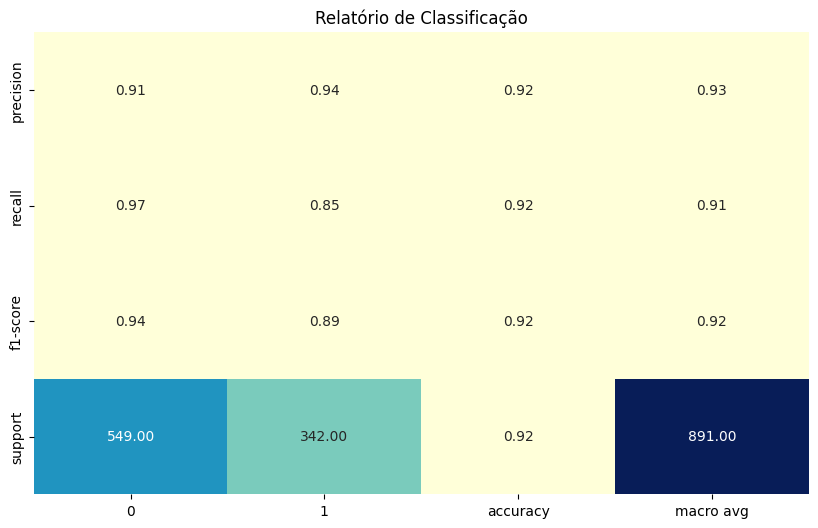

In [39]:
from sklearn.metrics import classification_report

# funcao para exibir o relatorio de classificacao
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)

    # ajusta o tamanho do grafico
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report.iloc[:-1, :].T, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
    plt.title("Relatório de Classificação")
    plt.show()

# exibe o relatorio de classificacao
print_classification_report(y_train, best_rf.predict(X_train))

In [45]:
from sklearn.decomposition import PCA

# Aplicando PCA
pca = PCA(n_components=5)  # ajustar o número de componentes
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

              precision    recall  f1-score     support
0              0.821490  0.863388  0.841918  549.000000
1              0.761146  0.698830  0.728659  342.000000
accuracy       0.800224  0.800224  0.800224    0.800224
macro avg      0.791318  0.781109  0.785288  891.000000
weighted avg   0.798328  0.800224  0.798445  891.000000


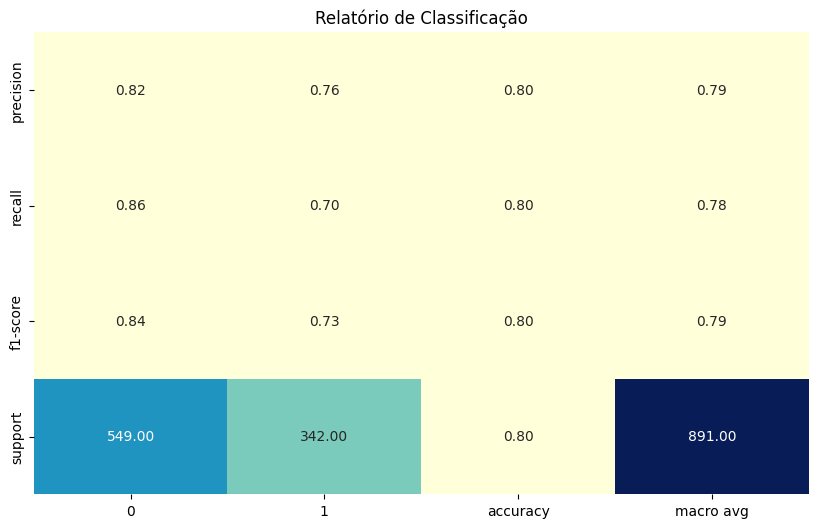

In [51]:
# regressao logistica
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print_classification_report(y_train, lr.predict(X_train))

              precision    recall  f1-score     support
0              0.971581  0.996357  0.983813  549.000000
1              0.993902  0.953216  0.973134  342.000000
accuracy       0.979798  0.979798  0.979798    0.979798
macro avg      0.982742  0.974787  0.978474  891.000000
weighted avg   0.980149  0.979798  0.979714  891.000000


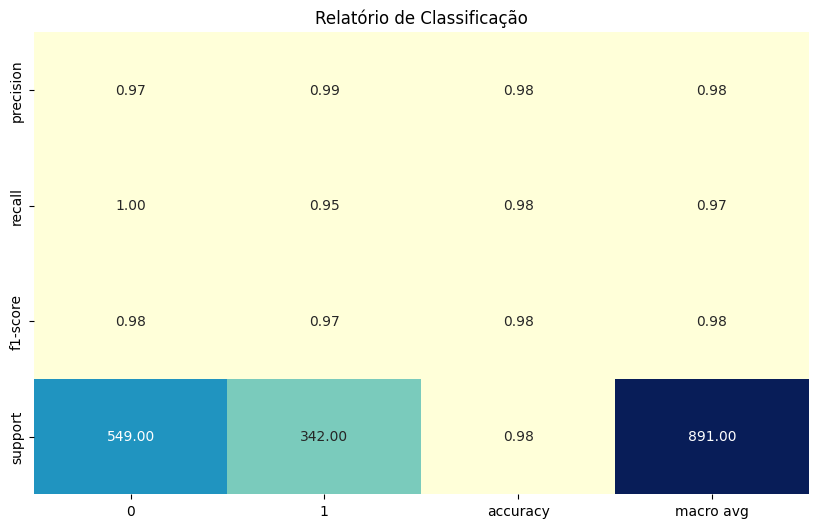

In [52]:
# arvore de decisao
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print_classification_report(y_train, dt.predict(X_train))

              precision    recall  f1-score     support
0              0.830909  0.832423  0.831665  549.000000
1              0.730205  0.728070  0.729136  342.000000
accuracy       0.792368  0.792368  0.792368    0.792368
macro avg      0.780557  0.780246  0.780401  891.000000
weighted avg   0.792255  0.792368  0.792311  891.000000


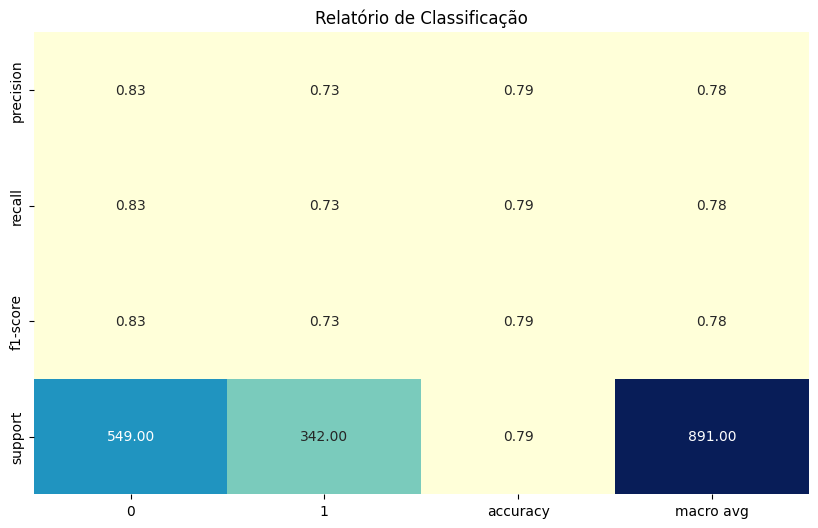

In [53]:
# classificador bayesiano
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
print_classification_report(y_train, nb.predict(X_train))